In [1]:
! pip install langchain langgraph langchain-anthropic

In [2]:
import getpass
import os
if "ANTHROPIC_API_KEY" not in os.environ:
    os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter your Anthropic API key: ")


In [3]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0)

In [4]:
import sqlite3

def recreate_appointments_table():
    conn = sqlite3.connect("hospital.db")
    c = conn.cursor()
    c.execute("DROP TABLE IF EXISTS appointments")
    c.execute('''
        CREATE TABLE appointments (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            patient_name TEXT,
            age INTEGER,
            symptoms TEXT,
            doctor TEXT,
            date TEXT,
            time TEXT
        )
    ''')
    conn.commit()
    conn.close()

recreate_appointments_table()

# doctor_schedule = {
#     "Dr. Rahul Mehra (Dermatologist)": ["10:00", "11:00", "14:00"],
#     "Dr. Alice Smith (Neurologist)": ["09:00", "13:00", "15:00"],
#     "Dr. John Lee (General Physician)": ["10:00", "12:00", "16:00"],
#     "Dr. Priya Patel (General Physician)": ["09:30", "11:30", "14:30"],
#     "Dr. Emily Wong (Pulmonologist)":["10:00", "12:00", "16:00"]
# }
doctor_info = {
    "Dr. Rahul Mehra (Dermatologist)": {
        "symptoms": ["skin rash", "acne", "eczema"],
        "schedule": ["10:00", "11:00", "14:00"]
    },
    "Dr. Alice Smith (Neurologist)": {
        "symptoms": ["headache", "dizziness"],
        "schedule": ["09:00", "13:00", "15:00"]
    },
    "Dr. John Lee (General Physician)": {
        "symptoms": ["fever", "body ache", "cold"],
        "schedule": ["10:00", "12:00", "16:00"]
    },
    "Dr. Priya Patel (General Physician)": {
        "symptoms": ["general issues"],
        "schedule": ["09:30", "11:30", "14:30"]
    },
    "Dr. Emily Wong (Pulmonologist)": {
        "symptoms": ["cough", "shortness of breath"],
        "schedule": ["10:00", "12:00", "16:00"]
    }
}


In [5]:
# state schema defined to hold info
from pydantic import BaseModel, Field
from typing import Optional, Literal

class PatientDetails(BaseModel):
    name: Optional[str]
    age: Optional[int]
    symptoms: Optional[str]

class AppointmentDetails(BaseModel):
    date: Optional[str]
    time: Optional[str]

class State(BaseModel):
    user_input: str
    patient_details: Optional[PatientDetails] = None
    appointment_details: Optional[AppointmentDetails] = None
    intent: Optional[str] = None
    next_action: Optional[str] = None
    has_history: Optional[bool] = None
    already_has_appointment: Optional[bool] = None
    is_available: Optional[bool] = None
    doctor_recommendation: Optional[str] = None
    final_response: Optional[str] = None
    


In [6]:
# define structured outputs to pass data from llm based step
class ExtractedEntitiesOutput(BaseModel):
    patient_details: PatientDetails = Field(
        description="Information about the patient, including name, age, and symptoms."
    )
    appointment_details: AppointmentDetails = Field(
        description="Preferred appointment date and time from the user."
    )

class IntentClassifierOutput(BaseModel):
    intent: str = Field(
        description="The tool name that should be used to handle the user's question."
    )
    intent_classifier_analysis: Optional[str] = Field(
        default=None, description="A summary of the intent classifier."
    )

class RoutingDecisionOutput(BaseModel):
    next_action: Literal[
        "check_patient_history",
        "check_existing_appointment",
        "collect_info",
    ] = Field(
        description="The next step the agent should take in the workflow."
    )

In [7]:
#  prompt used to guide llm 
from langchain_core.prompts import ChatPromptTemplate

entity_prompt = ChatPromptTemplate.from_template("""
You are a helpful assistant that extracts patient and appointment info.

Extract the following from the input:
- Name (if available or use a placeholder like "Unknown")
- Age (if mentioned or leave as null)
- Symptoms
- Date and Time (for the appointment)

Return as JSON like this:
{{
  "patient_details": {{
    "name": "John Doe",
    "age": 30,
    "symptoms": "headache"
  }},
  "appointment_details": {{
    "date": "2023-10-20",
    "time": "15:00"
  }}
}}

Input: {input}
""")

intent_prompt = ChatPromptTemplate.from_template("""
Classify the user's intent into one of the following:
- book_appointment
- cancel_appointment
- reschedule_appointment
- inquire
- other

Input: {input}
Intent:
""")

router_prompt = ChatPromptTemplate.from_template("""
Based on the user intent: {intent}, choose the next action:
- collect_missing_info
- check_patient_history
- check_existing_appointment
- cancel_appointment
- reschedule_appointment

Respond with ONLY one of the above options.
""")

In [8]:
# every function take a state and return and update it.
def state_initializer(state: dict) -> State:
    return State(user_input=state.user_input)

def entity_extractor(state: State) -> State:
    prompt = entity_prompt.format(input=state.user_input)
    response = llm.invoke(prompt).content

    import json
    parsed = json.loads(response)

    state.patient_details = PatientDetails(**parsed.get("patient_details", {}))
    state.appointment_details = AppointmentDetails(**parsed.get("appointment_details", {}))
    return {
        "patient_details":state.patient_details,
        "appointment_details":state.appointment_details
    }

def intent_classifier(state: State) -> State:
    prompt = intent_prompt.format(input=state.user_input)
    state.intent = llm.invoke(prompt).content.strip()
    return {
        "intent":state.intent
    }

def agent_router(state: State) -> State:
    prompt = router_prompt.format(
        intent=state.intent,
    )
    response = llm.invoke(prompt).content.strip()
    state.next_action = response
    return state

In [9]:
# recomend doctor based on symptoms as per doctor_info
def recommend_doctor(state: State) -> State:
    symptom = (
        state.patient_details.symptoms.lower()
        if state.patient_details and state.patient_details.symptoms
        else ""
    )

    for doctor, info in doctor_info.items():
        for keyword in info["symptoms"]:
            if keyword in symptom:
                state.doctor_recommendation = doctor
                return {"doctor_recommendation": state.doctor_recommendation}

    # Default
    state.doctor_recommendation = "Dr. Priya Patel (General Physician)"
    return {"doctor_recommendation": state.doctor_recommendation}


In [10]:
def collect_missing_info(state:State) -> State:
    return state

In [11]:
def check_patient_history(state: State) -> State:
    return state

In [12]:
def check_existing_appointment(state: State) -> State:
    return state

In [13]:
def cancel_appointment(state: State) -> State:
    return state

In [14]:
def reschedule_appointment(state: State) -> State:
    return state

In [15]:
# from langchain.schema.output_parser import StrOutputParser
# import re
# # Prompt for extracting patient details
# patient_prompt = ChatPromptTemplate.from_messages([
#     ("system", "You are a helpful assistant. Extract the patient's name, age, and symptoms from the following message. Respond in this format:\n\nName: <name>\nAge: <age>\nSymptoms: <symptoms>"),
#     ("human", "{user_input}")
# ])

# # Prompt for extracting appointment details
# appointment_prompt = ChatPromptTemplate.from_messages([
#     ("system", "You are a helpful assistant. Extract the appointment date and time from the following message. Respond in this format:\n\nDate: <YYYY-MM-DD>\nTime: <HH:MM>"),
#     ("human", "{user_input}")
# ])

# def collect_info_from_user_input(state: State) -> State:
#     # Extract patient details if missing
#     if not state.patient_details:
#         chain = patient_prompt | llm | StrOutputParser()
#         output = chain.invoke({"user_input": state.user_input})
        
#         match = re.search(r"Name:\s*(.+?)\nAge:\s*(\d+)\nSymptoms:\s*(.+)", output, re.I)
#         if match:
#             state.patient_details = PatientDetails(
#                 name=match.group(1).strip(),
#                 age=int(match.group(2)),
#                 symptoms=match.group(3).strip()
#             )

#     # Extract appointment details if missing
#     if not state.appointment_details:
#         chain = appointment_prompt | llm | StrOutputParser()
#         output = chain.invoke({"user_input": state.user_input})
        
#         match = re.search(r"Date:\s*(\d{4}-\d{2}-\d{2})\nTime:\s*([\d:apm\s]+)", output, re.I)
#         if match:
#             state.appointment_details = AppointmentDetails(
#                 date=match.group(1).strip(),
#                 time=match.group(2).strip()
#             )

#     return state

In [16]:
def check_doctor_availability(state: State) -> State:
    doctor = state.doctor_recommendation
    date = state.appointment_details.date
    requested_time = state.appointment_details.time

    available_times = doctor_info.get(doctor, {}).get("schedule", [])

    # Fetch already booked times from DB
    conn = sqlite3.connect("hospital.db")
    c = conn.cursor()
    c.execute('''SELECT time FROM appointments WHERE doctor = ? AND date = ?''', (doctor, date))
    booked_times = [row[0] for row in c.fetchall()]
    conn.close()

    free_times = [t for t in available_times if t not in booked_times]

    # If user explicitly requested a time
    # if requested_time:
    if requested_time in free_times:
        state.is_available = True
    else:
        state.is_available = False
        state.final_response = f"Sorry, the slot is already booked  {requested_time} on {date}."

    return state


In [17]:
def schedule_appointment(state: State) -> State:
    if not state.is_available:
        return state

    name = state.patient_details.name or "the patient"
    age = state.patient_details.age or 0
    symptoms = state.patient_details.symptoms or "N/A"
    date = state.appointment_details.date
    time = state.appointment_details.time
    doctor = state.doctor_recommendation
    # Save in database
    conn = sqlite3.connect("hospital.db")
    c = conn.cursor()
    c.execute('''
        INSERT INTO appointments (patient_name, age, symptoms, doctor, date, time)
        VALUES (?, ?, ?, ?, ?, ?)
    ''', (name, age, symptoms, doctor, date, time))
    conn.commit()
    conn.close()

    state.final_response = (
        f"Appointment confirmed for {name} with {doctor} on {date} at {time}."
    )
    return state


In [19]:
from langgraph.graph import StateGraph,END
workflow = StateGraph(State)

workflow.add_node("state_initializer", state_initializer)
workflow.add_node("entity_extractor", entity_extractor)
workflow.add_node("intent_classifier", intent_classifier)
workflow.add_node("agent_router", agent_router)
workflow.add_node("collect_missing_info",collect_missing_info)
workflow.add_node("check_patient_history",check_patient_history)
workflow.add_node("check_existing_appointment",check_existing_appointment)
workflow.add_node("recommend_doctor",recommend_doctor)
workflow.add_node("cancel_appointment",cancel_appointment)
workflow.add_node("reschedule_appointment",reschedule_appointment)
# workflow.add_node("collect_info_from_user_input", collect_info_from_user_input)
workflow.add_node("check_doctor_availability", check_doctor_availability)
workflow.add_node("schedule_appointment", schedule_appointment)

workflow.set_entry_point("state_initializer")
workflow.add_edge("state_initializer", "entity_extractor")
workflow.add_edge("state_initializer", "intent_classifier")

workflow.add_edge("entity_extractor", "agent_router")
workflow.add_edge("intent_classifier", "agent_router")

workflow.add_conditional_edges(
    "agent_router",
    lambda state: state.next_action,
    {
        "collect_missing_info":"collect_missing_info",
        "check_patient_history":"check_patient_history",
        "check_existing_appointment":"check_existing_appointment",
        "cancel_appointment":"cancel_appointment",
        "reschedule_appointment":"reschedule_appointment"

    }
)
workflow.add_edge("collect_missing_info","recommend_doctor")
workflow.add_edge("check_patient_history","recommend_doctor")
workflow.add_edge("check_existing_appointment","recommend_doctor")
workflow.add_edge("cancel_appointment","recommend_doctor")
workflow.add_edge("reschedule_appointment","recommend_doctor")

workflow.add_edge("recommend_doctor", "check_doctor_availability")
workflow.add_edge("check_doctor_availability", "schedule_appointment")
workflow.add_edge("schedule_appointment", END)

In [20]:
app = workflow.compile()

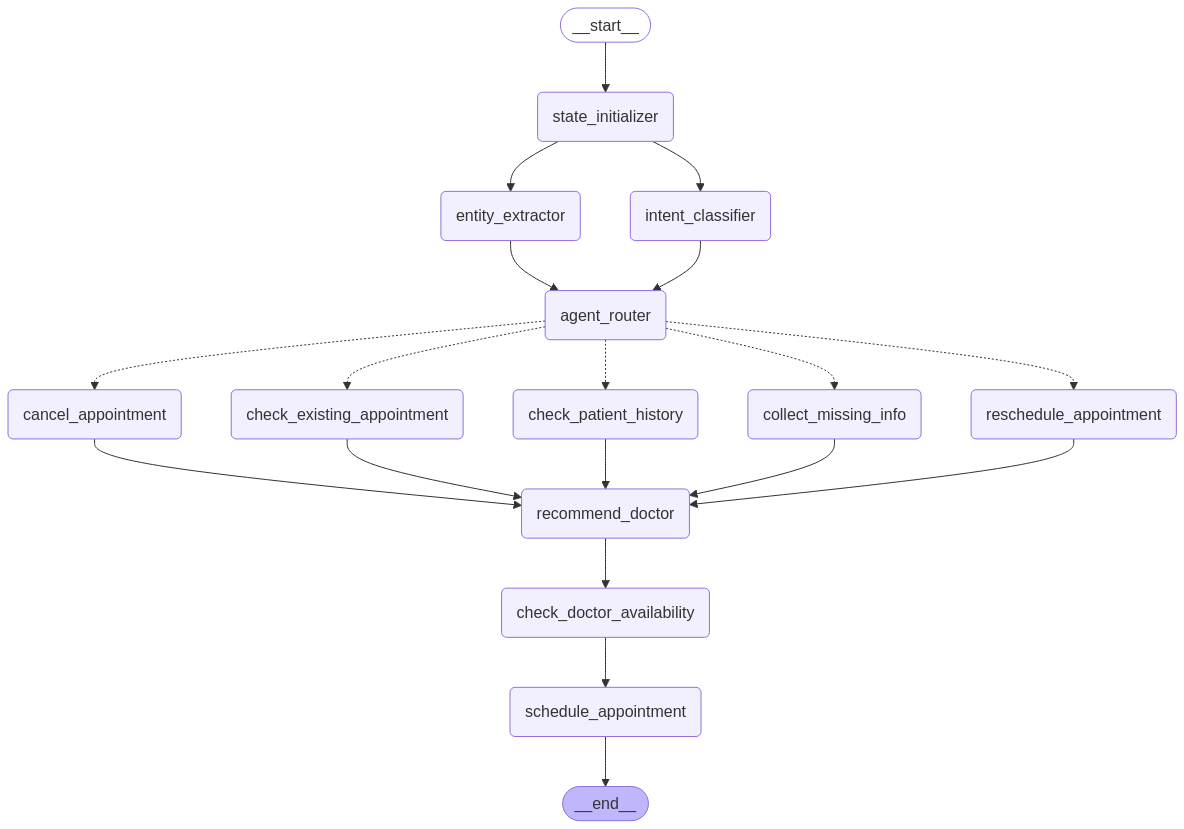

In [21]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [22]:
final_state = app.invoke({"user_input": "My name is Mahi my age is 28 and I need to see a doctor for cough on 22-03-2025 at 10:00"})
final_state


{'user_input': 'My name is Mahi my age is 28 and I need to see a doctor for cough on 22-03-2025 at 10:00',
 'patient_details': PatientDetails(name='Mahi', age=28, symptoms='cough'),
 'appointment_details': AppointmentDetails(date='2025-03-22', time='10:00'),
 'intent': 'Intent: book_appointment\n\nExplanation: The user is providing their personal information (name and age) and expressing a need to see a doctor for a specific medical concern (cough) on a specific date (22-03-2025) and time (10:00). This clearly indicates they want to book a new appointment.',
 'next_action': 'collect_missing_info',
 'is_available': True,
 'doctor_recommendation': 'Dr. Emily Wong (Pulmonologist)',
 'final_response': 'Appointment confirmed for Mahi with Dr. Emily Wong (Pulmonologist) on 2025-03-22 at 10:00.'}

In [23]:
def check_appointments():
    conn = sqlite3.connect("hospital.db")
    c = conn.cursor()
    c.execute("SELECT * FROM appointments")
    rows = c.fetchall()
    conn.close()

    if rows:
        print("Stored Appointments:")
        for row in rows:
            print(row)
    else:
        print("No appointments found.")


In [24]:
check_appointments()


Stored Appointments:
(1, 'Mahi', 28, 'cough', 'Dr. Emily Wong (Pulmonologist)', '2025-03-22', '10:00')
